# Laboratorium 9. Wizja Komputerowa

**Uwaga:** Poniższy notebook jest stworzony z myślą o odpalaniu go w [Colaboratory](https://colab.research.google.com/), oznacza to, że przygotowane zadania zakładają uczenie modelu z użyciem GPU. Na zajęciach zostanie krótko omówione używanie Colaboratory. Na własną odpowiedzialność można używać własnego komputera do rozwiązania pracy domowej.

In [1]:
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

### CIFAR10
[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) to dataset zawierający 60 tysięcy kolorowych obrazków rozmiaru 32 $\times$ 32 pikseli należących do 10 różnych klas. Poniżej przykładowe wizualizacje.

Files already downloaded and verified
CIFAR10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


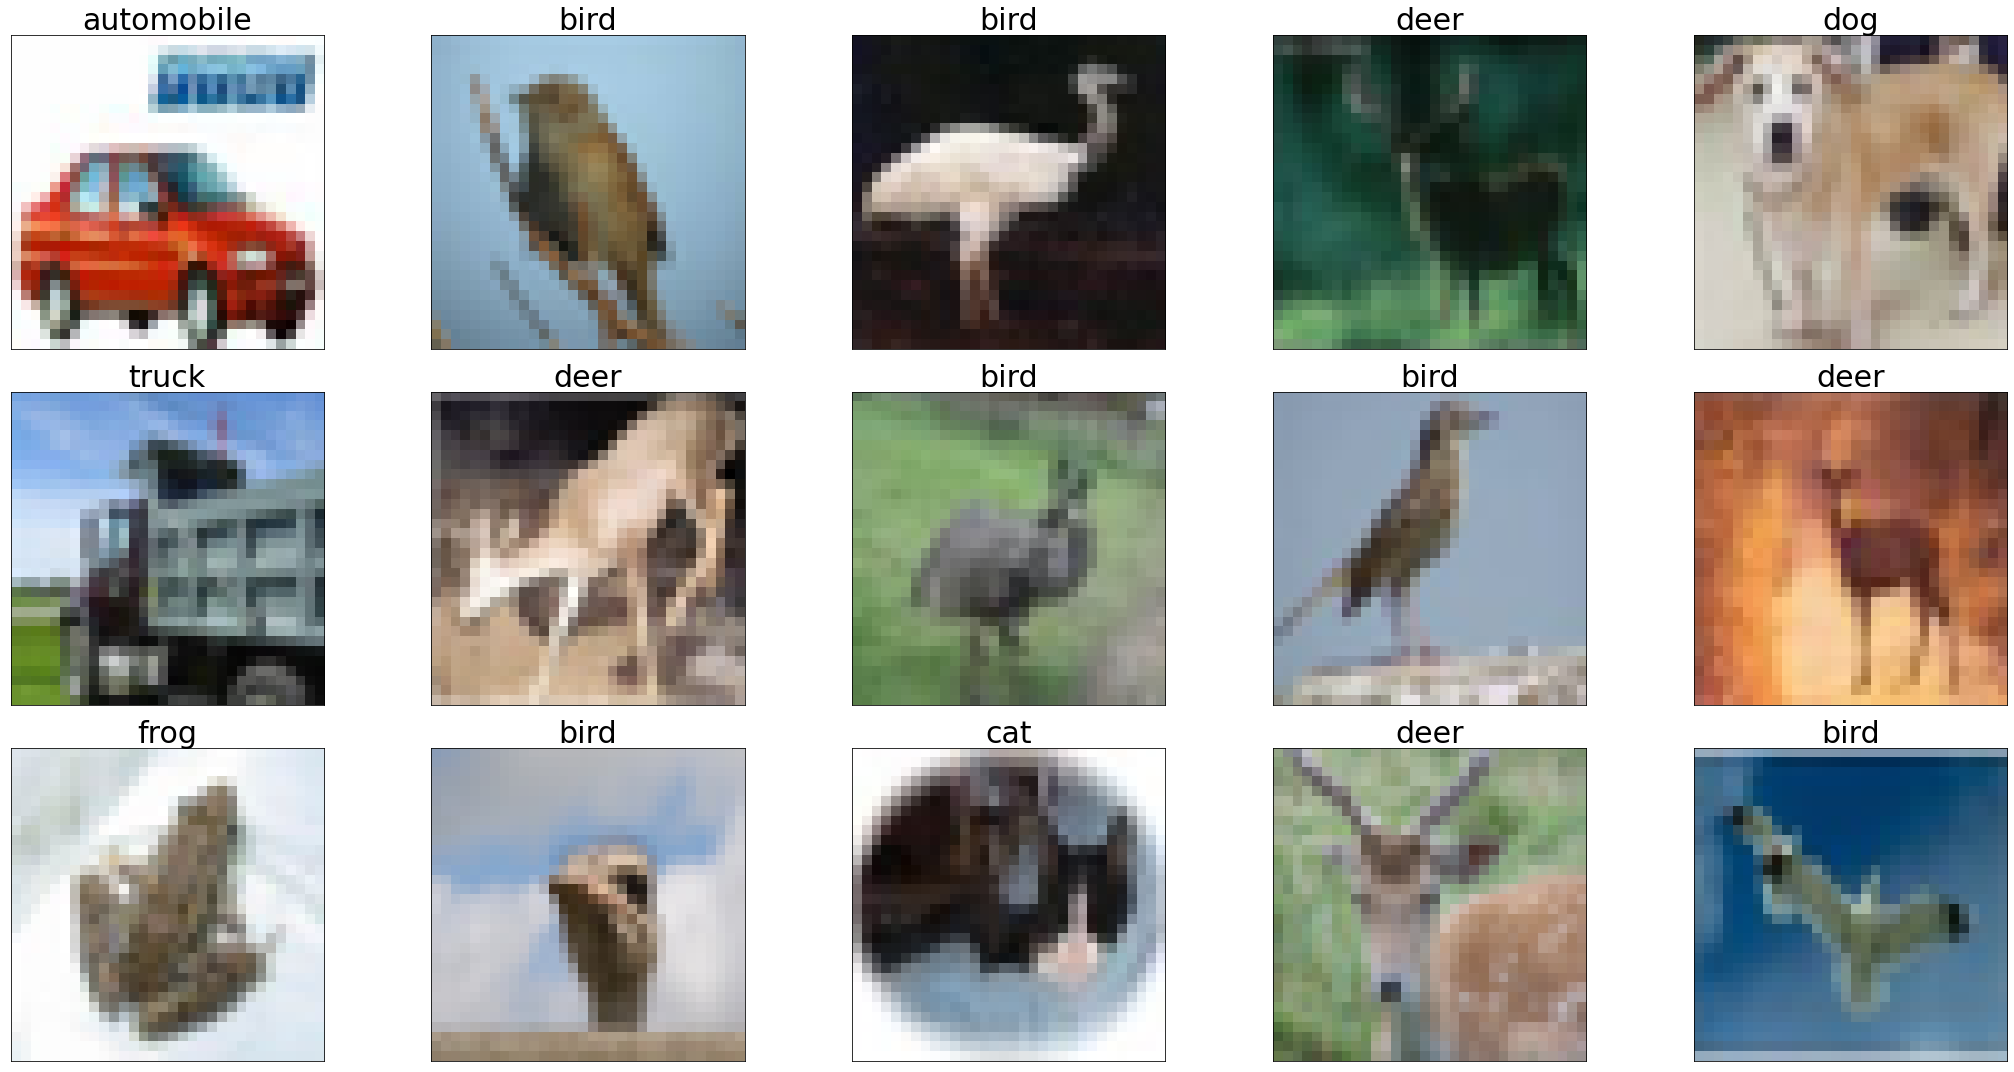

In [2]:
dataset = CIFAR10(root='.', train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
for x, y in loader:
    break

# prepare visualisations
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={'size': 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")

### Zadanie 1. Sieć Konwolucyjna na CIFAR10 (4 pkt.)

Zadaniem jest zaimplementowanie "od zera" sieci konwolucyjnej do klasyfikacji wieloklasowej na zbiorze CIFAR10. Należy zaimplementować zarówno model jak i pętle uczenia oraz ewaluacji. Twój kod powinien raportować *loss* w trakcie trenowania, testowania oraz *accuracy* na zbiorze testowym (opcjonalnie również na treningowym). Na koniec *accuracy* powinno osiągnąć wynik powyżej 75% na zbiorze testowym. Można korzystać z dowolnych mechanizmów dostępnych w PyTorchu.

Porady do zadania:

* Zwiększenie treningowego *batch size* może przyspieszyć uczenie, ale należy pamiętać, że, tak jak każdy hiperparametr, *batch_size* ma wpływ na proces uczenia.
* Przy dobieraniu architektury bądź hiperparametrów nie testować dłużej niż kilka epok (około 5), tak aby mieć szybki feedback. Dopiero po dobraniu powyższych rzeczy puścić dłuższe uczenie. Warto przy okazji wizualizować krzywe uczenia (funkcji kosztu) aby zwrócić uwagę na to kiedy koszt zaczyna się "wypłaszczać" i czy model przypadkowo nie overfituje (patrząc na wartości kosztu na zbiorze testowym)
* Dodatkowe (nadobowiązkowe) rzeczy do poprawienia wyniku: LR Schedule, Early Stopping.

In [3]:
# tutaj zdefiniuj swój model, nie zapomnij podziedziczyć po torch.nn.Module
import torch.nn as nn
from dataclasses import dataclass
from abc import ABC, abstractmethod

@dataclass()
class Params:
    num_classes: int = len(dataset.classes)
    dropout: float = 0.5
    PATH: str = './cifar_net.pth'

class Network(ABC):
    @abstractmethod
    def forward():
        ":returns output params of forward step of network"
        
class MyNetwork(nn.Module, Network):
    def __init__(self, num_classes = Params.num_classes, dropout = Params.dropout) -> None:
        super().__init__()
        self.convolution_structure = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),
        )
        self.classifier = nn.Sequential(
        nn.Dropout(p = dropout),
        nn.Linear(256*4*4, 1024),
        nn.ReLU(),
        nn.Dropout(p = dropout),
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.Linear(512, num_classes)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.convolution_structure(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [18]:
# tutaj uzupełnij ładowanie danych treningowych i testowych
import torchvision
from torchvision.transforms import Normalize, Resize, ToTensor, Lambda
def calculate_mean_and_std() -> Tuple[float, float]:
    train_data = CIFAR10(root='.', download=False, train=True, transform= ToTensor())
    mean = (train_data.data / 255).mean().item()
    std = (train_data.data / 255).std().item()
    return mean, std

mean, std = calculate_mean_and_std()
train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform = torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            Normalize((mean,), (std,)),
                        ])
                       )

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform = torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor(),
                           Normalize((mean,), (std,)),
                       ])
                      )
print(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=600, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=600, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4733630004850874,), std=(0.25156892506322026,))
           )


In [19]:
# tutaj zaimplementuj pętle uczenia ze wszystkimi potrzebnymi hiperparametrami
net = MyNetwork()

# OPTIMIZER AND CRITERION
optimizer = optim.Adam(params = net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# DELEGOWANIE OBLICZEŃ NA GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import gc
gc.collect()
print(device)
net.to(device)
logs = {}
num_epochs = 8
for epoch in range(num_epochs):
    logs = {}
    total_correct = 0
    total_loss = 0
    total_images = 0
    total_val_loss = 0
    # TRENING
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_images+= labels.size(0)
        # STATS
        _, predicted = torch.max(outputs.detach(), 1)
        correct = (predicted == labels).sum().item()
        total_correct+=correct
        total_loss+=loss.item()
    logs['log loss'] = total_loss / total_images
    logs['Accuracy'] = ((total_correct / total_images) * 100)
    print('Epoka [{}/{}], Strata: {:.4f}, Dokładność: {:.2f}%'.format(epoch + 1, num_epochs, 
                                                                  (total_loss / total_images),
                                                                  (total_correct / total_images) * 100))
    # TEST
    with torch.no_grad():
        correct = 0
        total = 0
        total_losss =0
        for data, target in test_loader:
            images = data.to('cuda:0')
            labels = target.to('cuda:0')
            outputs = net(images)
            _, predicted = torch.max(outputs.detach(), 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_losss += loss.item()
            accuracy = correct / total
        print('Dokładność na zbiorze testowym: {} %'.format(100 * correct / total))
        logs['val_' + 'log loss'] = total_losss/total
        logs['val_' + 'Accuracy'] = ((correct / total) * 100)
        print('-'*80)  
print('Trening zakończony')
torch.save(net.state_dict(), Params.PATH)
# W pierwszym treningu dokładność na zbiorze treningowym wyniosła 75.62%, z jakiegoś powodu teraz spadło poniżej oczekiwań 

cuda:0
Epoka [1/8], Strata: 0.0022, Dokładność: 51.06%
Dokładność na zbiorze testowym: 63.22 %
--------------------------------------------------------------------------------
Epoka [2/8], Strata: 0.0014, Dokładność: 69.63%
Dokładność na zbiorze testowym: 72.44 %
--------------------------------------------------------------------------------
Epoka [3/8], Strata: 0.0011, Dokładność: 76.86%
Dokładność na zbiorze testowym: 76.2 %
--------------------------------------------------------------------------------
Epoka [4/8], Strata: 0.0009, Dokładność: 81.25%
Dokładność na zbiorze testowym: 78.05 %
--------------------------------------------------------------------------------
Epoka [5/8], Strata: 0.0007, Dokładność: 84.38%
Dokładność na zbiorze testowym: 80.16 %
--------------------------------------------------------------------------------
Epoka [6/8], Strata: 0.0006, Dokładność: 86.92%
Dokładność na zbiorze testowym: 81.02 %
-------------------------------------------------------------

## Augmentacje

Pakiet `torchvision` implementuje wiele różnych transformacji do danych, część z nich jest użyteczna do tzw. augmentacji danych. Augmentacja danych to mechanizm "sztucznego" zwiększania datasetu treningowego poprzez dodawanie do niego zmodyfikowanych kopii danych, które już w nim istnieją. Augmentacja jest szczególnie użyteczna kiedy nasz dataset ma małą liczbę przykładów do uczenia skomplikowanych sieci neuronowych. 

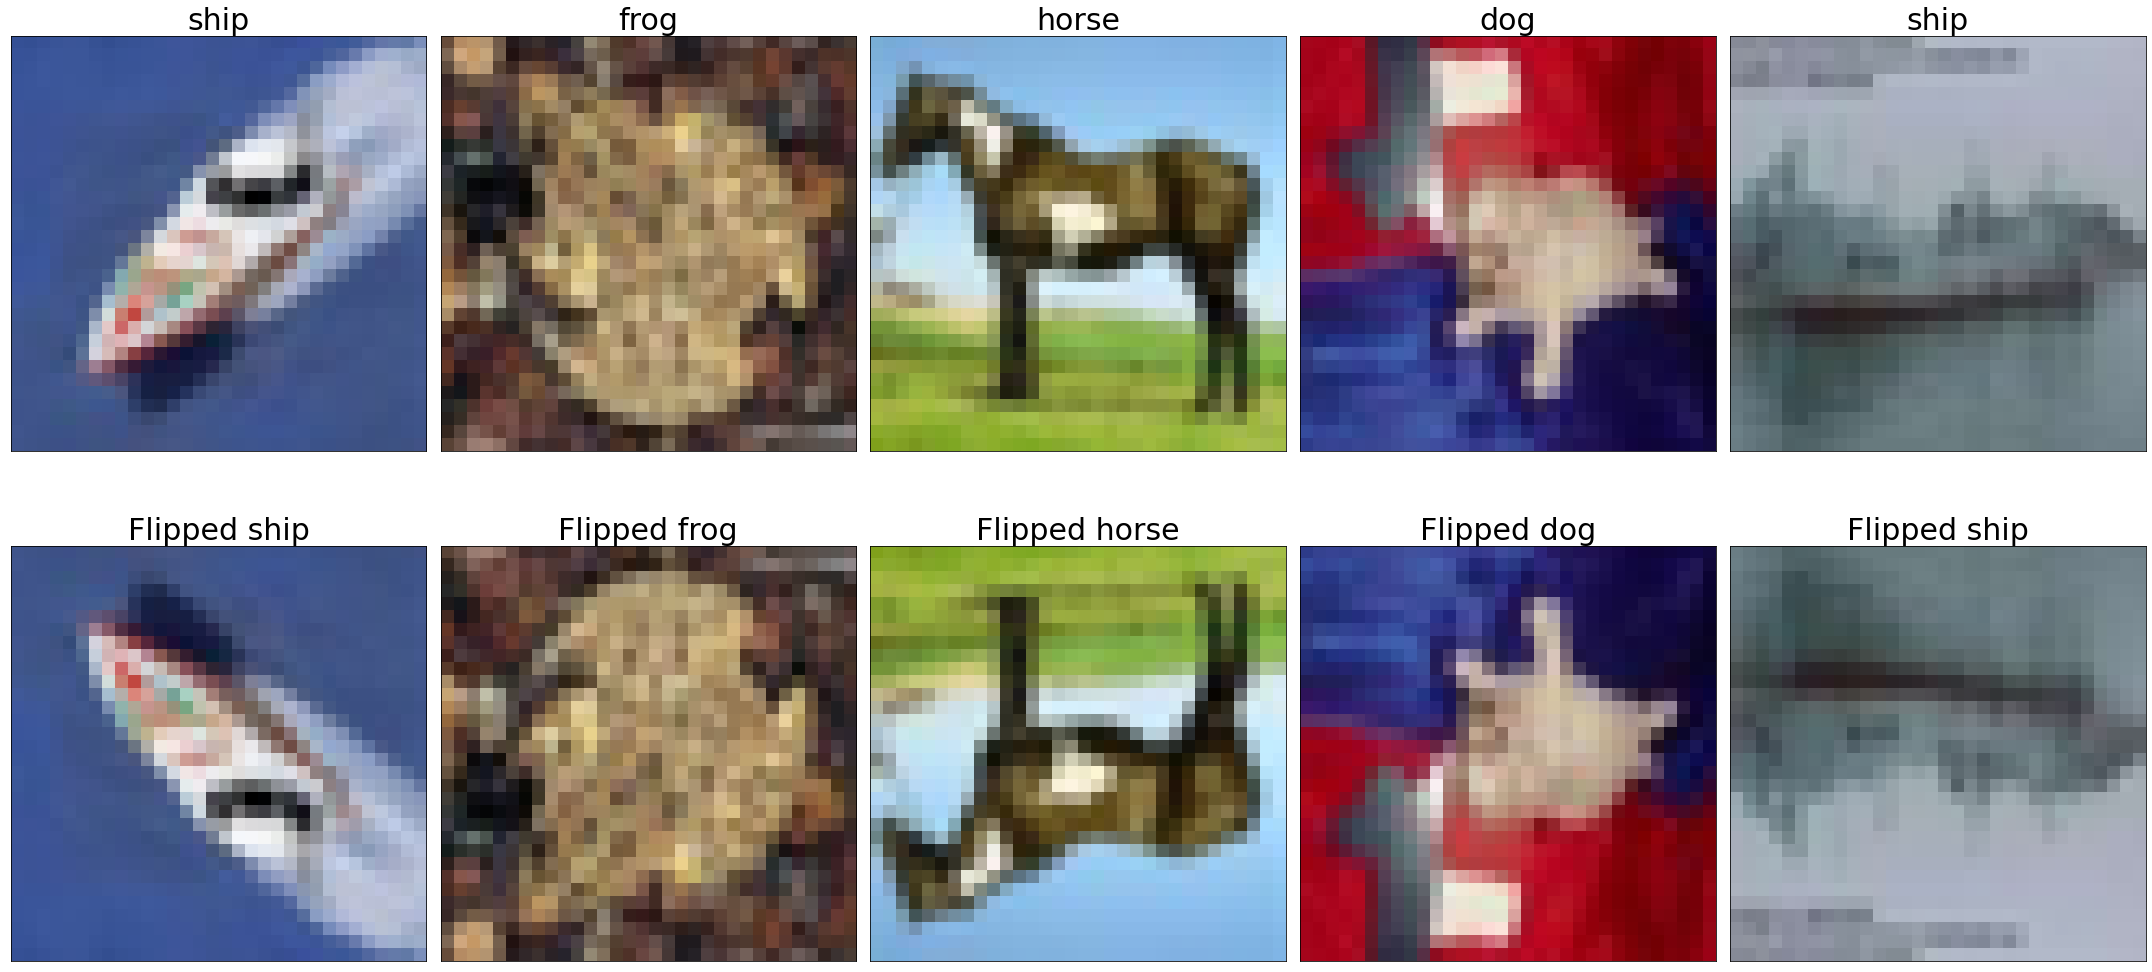

In [20]:
from torchvision.transforms import RandomVerticalFlip

# load test set
dataset = CIFAR10(root='.', train=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# prepare a random flip
flip = RandomVerticalFlip(p=1) 

# load some data
for x, y in loader:
    break
    

# visualise the flipping
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 15))

for img, label, ax in zip(x, y, axes[0]):
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(f"{dataset.classes[label]}", fontdict={'size': 30})
    ax.set_xticks([])
    ax.set_yticks([])
    
for img, label, ax in zip(x, y, axes[1]):
    ax.imshow(np.transpose(flip(img), (1, 2, 0)))
    ax.set_title(f"Flipped {dataset.classes[label]}", fontdict={'size': 30})
    ax.set_xticks([])
    ax.set_yticks([])


fig.tight_layout()

### Zadanie 2. Augmentacja danych (1 pkt.)

Używając funkcjonalności dostępnych w [`torchvision.transforms`](https://pytorch.org/docs/stable/torchvision/transforms.html) dodaj augmentacje danych do datasetu treningowego, zobacz o ile poprawia to wynik twojego modelu z poprzedniego zadania. W razie wątpliwości najlepiej przeszukać internet w poszukiwaniu typowych augmentacji dla CIFAR10.

In [24]:
# tutaj dodaj wybrane augumentcje danych treningowych i załaduj testowe
from torchvision.transforms import RandomVerticalFlip,RandomHorizontalFlip,RandomCrop
train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform = torchvision.transforms.Compose([
                           RandomVerticalFlip(p=1),
                           torchvision.transforms.ToTensor(),
                           Normalize((mean,), (std,)),
                       ])
                      )

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform = torchvision.transforms.Compose([
                           RandomVerticalFlip(p=1),
                           torchvision.transforms.ToTensor(),
                           Normalize((mean,), (std,)),
                       ])
                      )


train_loader = DataLoader(train_dataset, batch_size=600, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=600, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
# tutaj powtórz pętle uczenia z poprzedniego zadania
# Ładowanie zapisanego modelu
# net = MyNetwork()
# net.load_state_dict(torch.load(PATH))

net = MyNetwork()

# OPTIMIZER AND CRITERION
optimizer = optim.Adam(params = net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# DELEGOWANIE OBLICZEŃ NA GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)
logs = {}
num_epochs = 8
for epoch in range(num_epochs):
    logs = {}
    total_correct = 0
    total_loss = 0
    total_images = 0
    total_val_loss = 0
    # TRENING
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_images+= labels.size(0)
        # STATS
        _, predicted = torch.max(outputs.detach(), 1)
        correct = (predicted == labels).sum().item()
        total_correct+=correct
        total_loss+=loss.item()
    logs['log loss'] = total_loss / total_images
    logs['Accuracy'] = ((total_correct / total_images) * 100)
    print('Epoka [{}/{}], Strata: {:.4f}, Dokładność: {:.2f}%'.format(epoch + 1, num_epochs, 
                                                                  (total_loss / total_images),
                                                                  (total_correct / total_images) * 100))
    # TEST
    with torch.no_grad():
        correct = 0
        total = 0
        total_losss =0
        for data, target in test_loader:
            images = data.to('cuda:0')
            labels = target.to('cuda:0')
            outputs = net(images)
            _, predicted = torch.max(outputs.detach(), 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_losss += loss.item()
            accuracy = correct / total
        print('Dokładność na zbiorze testowym: {} %'.format(100 * correct / total))
        logs['val_' + 'log loss'] = total_losss/total
        logs['val_' + 'Accuracy'] = ((correct / total) * 100)
        print('-'*80)  
print('Trening zakończony')
torch.save(net.state_dict(), './cifar10_aug')
# correct = 0
# total = 0
# with torch.no_grad():
#     for data in test_dataset:
#         images, labels = data
#         outputs = net(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
# print('Dokładność sieci na 10000 przykładowych obrazków: %d %%' % (100 * correct / total))

cuda:0
Epoka [1/8], Strata: 0.0022, Dokładność: 51.79%
Dokładność na zbiorze testowym: 64.46 %
--------------------------------------------------------------------------------
Epoka [2/8], Strata: 0.0014, Dokładność: 70.28%
Dokładność na zbiorze testowym: 72.91 %
--------------------------------------------------------------------------------
Epoka [3/8], Strata: 0.0011, Dokładność: 77.14%
Dokładność na zbiorze testowym: 76.25 %
--------------------------------------------------------------------------------
Epoka [4/8], Strata: 0.0009, Dokładność: 81.15%
Dokładność na zbiorze testowym: 79.0 %
--------------------------------------------------------------------------------
Epoka [5/8], Strata: 0.0008, Dokładność: 84.18%
Dokładność na zbiorze testowym: 79.43 %
--------------------------------------------------------------------------------
Epoka [6/8], Strata: 0.0007, Dokładność: 86.52%
Dokładność na zbiorze testowym: 80.34 %
-------------------------------------------------------------

## Ataki Adwersarialne

Jednym z (ciągle nierozwiązanych) problemów w sieciach neuronowych, zwłaszcza systemów wizyjnych są tzw. ataki adwersarialne. Przy takim ataku, "agresor" ma pewien ograniczony dostęp do modelu (np. dostęp do logitów na wyjściu sieci) i używając tych informacji jest w stanie tak zmodyfikować wejście do sieci w takim sposób aby uzyskać błędne, a nawet specyficzne, wyjście. Poniższy kod prezentuje metodę **F**ast **G**radient **S**ign **M**ethod, która modyfikuje wejście do sieci za pomocą gradientu funkcji kosztu po tym wejściu.

<font size=4>$$ \hat{x} = x + \epsilon \space \textit{sign}\big(\nabla_x \mathcal{L}(x, y)\big) $$ </font>

In [28]:
from torchvision.models import inception_v3
from torchvision.transforms import Compose, Resize, ToTensor
import torch.nn as nn
import numpy as np

from PIL import Image
import urllib.request
import io
import json 

In [29]:
# cast to tensor and resize to for inception v3
preprocess = Compose([Resize((299,299)), ToTensor()])

# some prepared images
img_names = ['bird.jpg', 'cat.jpg', 'dog.jpg', 'frog.jpg']
imgs_url = 'https://raw.githubusercontent.com/gmum/ml2021-22/master/lab/resources/'

# get images 
imgs = []
for img_name in img_names:
    url = imgs_url + '/' + img_name
    with urllib.request.urlopen(url) as u:
        f = io.BytesIO(u.read())

    img = preprocess(Image.open(f))
    imgs.append(img)
    
imgs = torch.stack(imgs)

# get ImageNet classes list
labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
with urllib.request.urlopen(labels_url) as url:
    s = url.read().decode("utf-8")
    labels = json.loads(s)

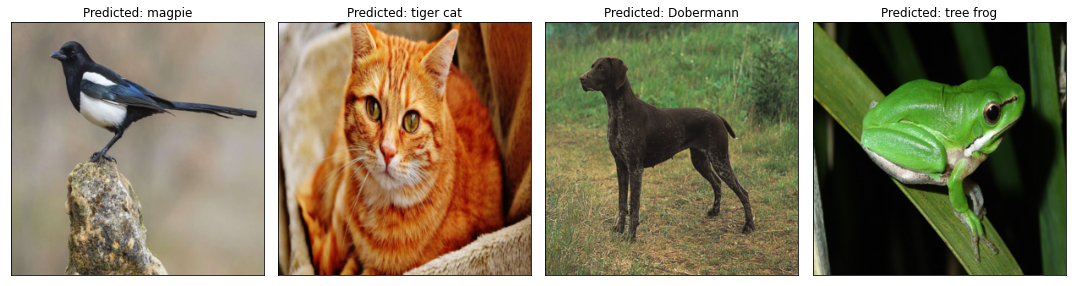

In [30]:
# load inception model 
model = inception_v3(pretrained=True) 
# set to eval, we don't want to modify it
model.eval()

# run the images through the model
output = model(imgs)
pred = torch.argmax(output, 1)

# visualisation
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
for ax, img, p in zip(axes, imgs, pred):
    ax.imshow(np.transpose(img.detach(), (1,2,0)))
    ax.set_title(f"Predicted: {labels[p]}")
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()

In [31]:
# prepare loss function for the method
loss = nn.CrossEntropyLoss()

# eps parameter for the FGSM
eps = 0.02

# inputs need to have gradients enabled!
imgs.requires_grad = True

# run the model and calculate the loss
outputs = model(imgs)
cost = loss(outputs, pred)

# get input gradients
grad = torch.autograd.grad(cost, imgs, create_graph=False)[0]

# FGSM 
adv_imgs = imgs + eps * grad.sign()
# clamp to the image range
adv_imgs = torch.clamp(adv_imgs, min=0, max=1).detach()
# save gradients for visualisation
grads = torch.clamp(grad.sign(), min=0, max=1).detach()

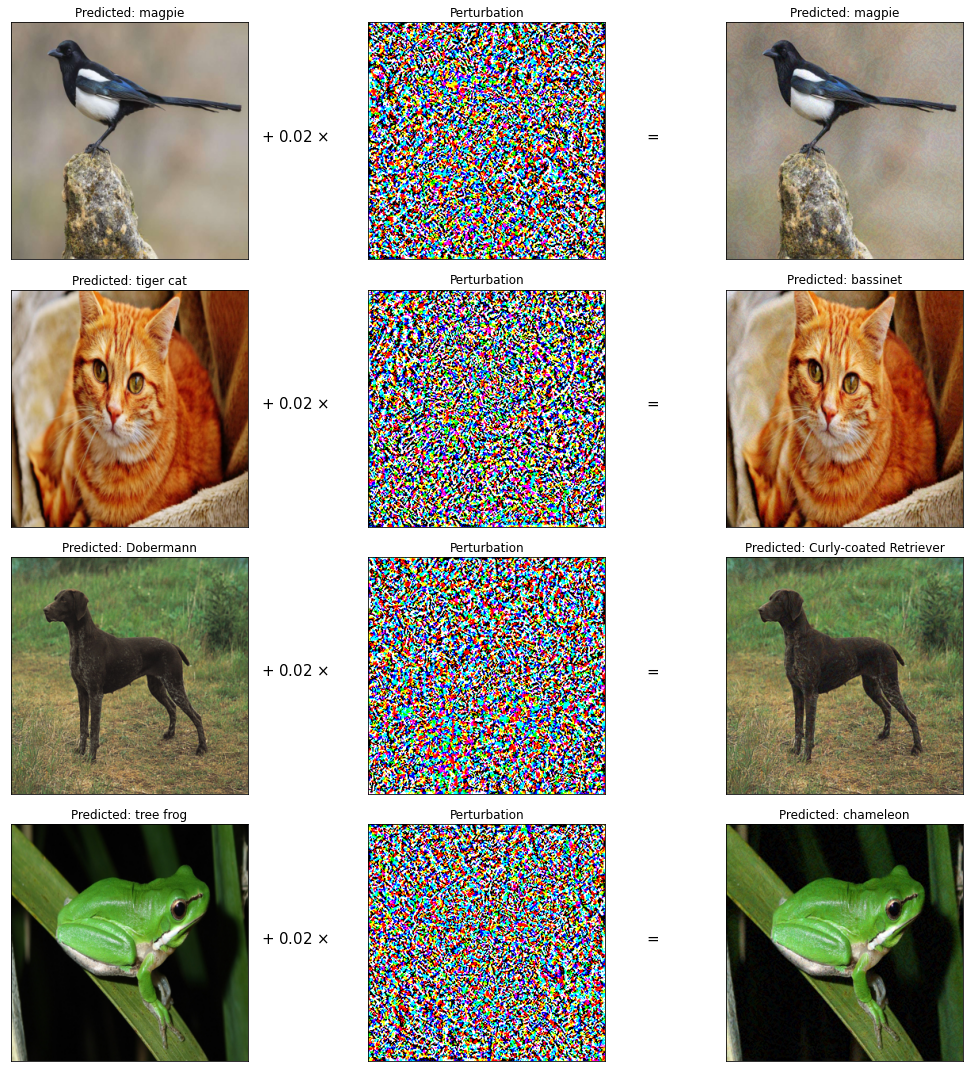

In [32]:
# run the advesarial samples through the network
output = model(adv_imgs)
adv_pred = torch.argmax(output, 1)

# visualisation
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for row, img, adv, p, adv_p, g in zip(axes, imgs, adv_imgs, pred, adv_pred, grads):
    row[0].imshow(np.transpose(img.detach(), (1,2,0)))
    row[0].set_title(f"Predicted: {labels[p]}")
    row[0].set_xticks([])
    row[0].set_yticks([])
    
    row[0].text(1.2,0.5, fr"+ {eps} $\times$", size=15, ha="center", transform=row[0].transAxes)
    
    row[1].imshow(np.transpose(g, (1,2,0)))
    row[1].set_title(f"Perturbation")
    row[1].set_xticks([])
    row[1].set_yticks([])
    
    row[1].text(1.2,0.5, "=", size=15, ha="center", transform=row[1].transAxes)
    
    row[2].imshow(np.transpose(adv.detach(), (1,2,0)))
    row[2].set_title(f"Predicted: {labels[adv_p]}")
    row[2].set_xticks([])
    row[2].set_yticks([])
    
fig.tight_layout()

### Zadanie 3. Przykłady Adwersarialne (2 pkt.)
1. Zobacz dla jakiego $\epsilon$ metoda FGSM zmieni predykcje dla Sroki z powyższego przykładu.
2. Zastosuj metodę FGSM dla swojego modelu i 4 losowych przykładów z CIFAR10 tak aby uzyskać wizualizacje podobną do powyższej.

`HINT`: Normalizacja, której normalnie używamy sprawia, że obrazki wychodzą poza typowe $[0, 1]$, można rozwiązać ten problem na dwa sposoby: <br> 1) "odwrócić" normalizację znając użyte średnią i odchylenie standardowe, <br> 2) nie używać normalizacji

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


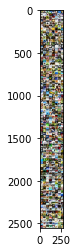

truck  deer  deer truck
Predicted:  truck  deer  deer   cat


In [33]:
# tutaj załaduj 4 losowe przykłady ze zbioru testowego, uważaj na normalizacje!
import matplotlib.pyplot as plt
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


net = MyNetwork()
net.load_state_dict(torch.load(Params.PATH))
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


In [34]:
# tutaj zastosuj metode FGSM do wygenerowania przykładów adwersarialnych
eps = 0.02
net.eval()
_, predicted = torch.max(outputs, 1)

loss = nn.CrossEntropyLoss()
images.requires_grad = True
outputs = net(images)
cost = loss(outputs, predicted)

grad = torch.autograd.grad(cost, images, create_graph=False)[0]
# FGSM 
adv_imgs = images + eps * grad.sign()
adv_imgs = torch.clamp(adv_imgs, min=0, max=1).detach()
grads = torch.clamp(grad.sign(), min=0, max=1).detach()
adv_imgs = images + eps * grad.sign()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


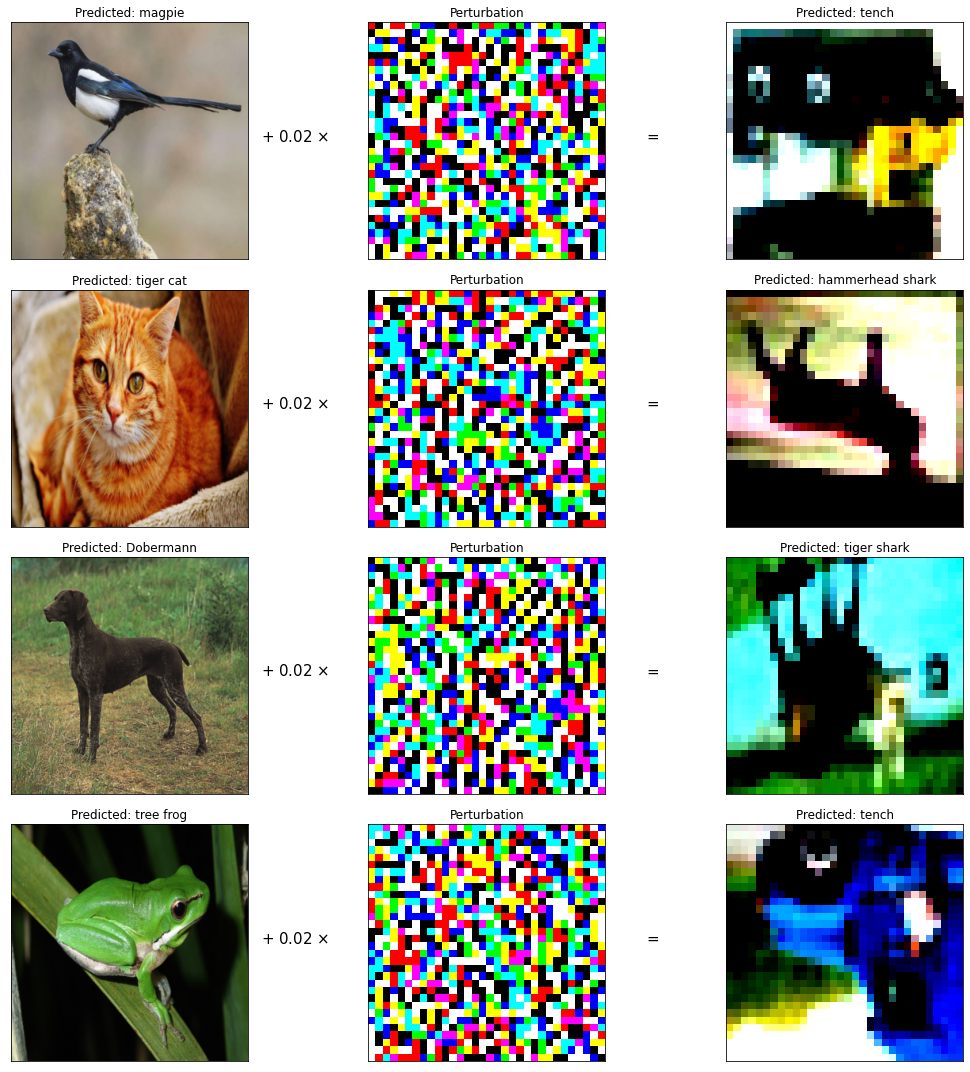

In [35]:
# tutaj przetestuj swój net i użyj wizualizacji z powyższego przykładu
output = net(adv_imgs)
adv_pred = torch.argmax(output, 1)

labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
with urllib.request.urlopen(labels_url) as url:
    s = url.read().decode("utf-8")
    labels = json.loads(s)
    
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for row, img, adv, p, adv_p, g in zip(axes, imgs, adv_imgs, pred, adv_pred, grads):
    row[0].imshow(np.transpose(img.detach(), (1,2,0)))
    row[0].set_title(f"Predicted: {labels[p]}")
    row[0].set_xticks([])
    row[0].set_yticks([])
    
    row[0].text(1.2,0.5, fr"+ {eps} $\times$", size=15, ha="center", transform=row[0].transAxes)
    
    row[1].imshow(np.transpose(g, (1,2,0)))
    row[1].set_title(f"Perturbation")
    row[1].set_xticks([])
    row[1].set_yticks([])
    
    row[1].text(1.2,0.5, "=", size=15, ha="center", transform=row[1].transAxes)
    
    row[2].imshow(np.transpose(adv.detach(), (1,2,0)))
    row[2].set_title(f"Predicted: {labels[adv_p]}")
    row[2].set_xticks([])
    row[2].set_yticks([])
    
fig.tight_layout()




**Z powyższych wyników można wnioskować, że model poradził sobie poniżej oczekiwań - atak okazał się skuteczny**